### Importing various modules

In [1]:
import glob # For reading all the files in a directory into a list
import rasterio # For reading and openning rasters
import matplotlib.pyplot as plt  # For ploting Data Frames
import pandas as pd   # For reading and manipulating Data Frames
import geopandas as gpd  # For reading and manipulating geographical data frames
import numpy as np  # For reading and manipulating arrays
from rasterio.mask import mask  # For masking unwanted pixels in  a raster
from rasterio.plot import show  # For showing the raster in a plot
import gdal, ogr, os, osr   
from skimage import exposure    # For creating real coloured composite images

In [2]:
ImgList = glob.glob('/home/emmanuel/Desktop/ML/Merged/*Raster.tif')
shapes = glob.glob('/home/emmanuel/Desktop/ML/PlanetscopeShapes/*shp')
shapes
ImgList

['/home/emmanuel/Desktop/ML/Merged/NewMergedRaster.tif']

In [3]:
rasterpath = ImgList[0]
raster1 = rasterio.open(rasterpath)

In [4]:
# Planetscope image cleaning function
def PlanetScope_Cleaner(raster_array):
    better_array  = np.where((raster_array <= 1) & (raster_array >= 0), raster_array, 0.0)
    return better_array

In [5]:
# Function that turns an array into a raster
def array2raster(rasterfn,newRasterfn,array):
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    cols = raster.RasterXSize
    rows = raster.RasterYSize
    driver = gdal.GetDriverByName("GTiff")
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [6]:
def NDVIcalc(nir, red):
    np.seterr(divide = 'ignore', invalid = 'ignore')
    NDVI = (nir - red)/(nir + red)
    return NDVI

In [7]:
def NDWIcalc(green, nir):
    np.seterr(divide = 'ignore', invalid = 'ignore')
    NDWI = (green - nir)/(green + nir)
    return NDWI

In [8]:
def IndexCleaner(INDEX):
    better_array  = np.where((INDEX <= 1) & (INDEX >= -1), INDEX, 0.0)
    return better_array

In [9]:
# Function that makes rasters of the blue, green, red, nir and NDVI 
def CreatRasters(rasterpath):
    blue_band, green_band, red_band, nir_band = rasterio.open(rasterpath).read()
    
    blue_band = blue_band*0.0001
    array2raster(rasterpath, rasterpath[:-6] + 'B1.tif', blue_band)
    
    green_band = green_band*0.0001
    array2raster(rasterpath, rasterpath[:-6] + 'B2.tif', green_band)
    
    red_band = red_band*0.0001
    array2raster(rasterpath, rasterpath[:-6] + 'B3.tif', red_band)
        
    nir_band = nir_band*0.0001
    array2raster(rasterpath, rasterpath[:-6] + 'B4.tif', nir_band)
    
    NDVI = NDVIcalc(nir_band, red_band)
    array2raster(rasterpath, rasterpath[:-6] + 'NDVI.tif', NDVI)
    
    NDWI = NDWIcalc(green_band, nir_band)
    array2raster(rasterpath, rasterpath[:-6] + 'NDWI.tif', NDWI)


In [10]:
CreatRasters(rasterpath)

In [11]:
blue_raster = rasterio.open(rasterpath[:-6] + 'B1.tif')
green_raster = rasterio.open(rasterpath[:-6] + 'B2.tif')
red_raster = rasterio.open(rasterpath[:-6] + 'B3.tif')
nir_raster = rasterio.open(rasterpath[:-6] + 'B4.tif')
NDVI_raster = rasterio.open(rasterpath[:-6] + 'NDVI.tif')
NDWI_raster = rasterio.open(rasterpath[:-6] + 'NDWI.tif')

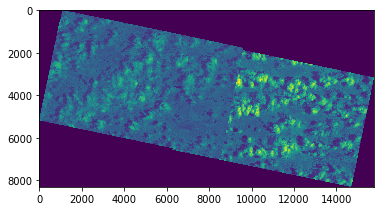

In [12]:
from rasterio.plot import plotting_extent
show(nir_raster.read(1))

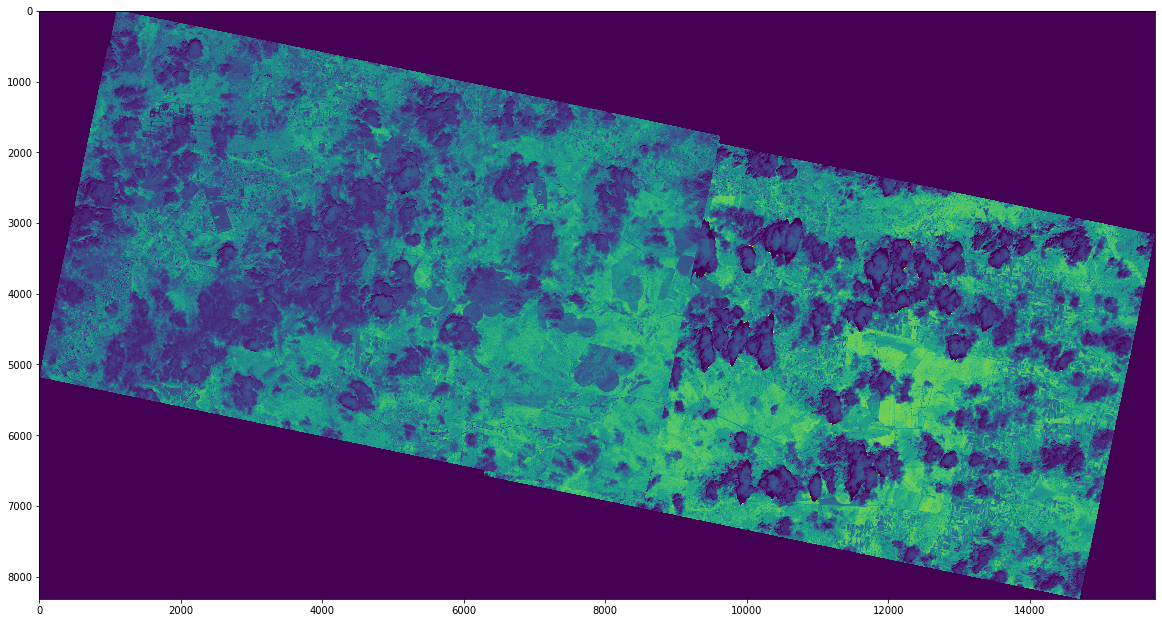

In [13]:
fi = plt.figure(figsize = (20,20))
plt.imshow(PlanetScope_Cleaner(NDVI_raster.read(1)))

In [14]:
NDVI_raster.read(1)[1500:2500, 1000:2000]

array([[0.42090306, 0.40889168, 0.4085028 , ..., 0.11240498, 0.12256548,
        0.13334489],
       [0.41994917, 0.40761724, 0.3969725 , ..., 0.11897834, 0.13479729,
        0.14611472],
       [0.39609572, 0.40075853, 0.40258107, ..., 0.1532218 , 0.16122378,
        0.15854302],
       ...,
       [0.19553728, 0.1945633 , 0.19495799, ..., 0.4447937 , 0.43571427,
        0.42330796],
       [0.19617707, 0.19574325, 0.19678177, ..., 0.44321918, 0.43607843,
        0.4269797 ],
       [0.19543317, 0.19526528, 0.19610476, ..., 0.44928092, 0.4417154 ,
        0.43453208]], dtype=float32)

In [15]:
# Get shape geometry in json format
def getFeatures(gdf):
    '''Function to parse features from GeoDataFrame in such a manner that rasterio wants them'''
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
#================================================================================================

In [16]:
# Function that gets the classes 
def getClasses1(shp, blue, green, red, nir, NDVI, NDWI):
    class_df = pd.DataFrame()
    df_ls = []
    img_blue = blue 
    img_green = green
    img_red = red
    img_nir = nir
    img_ndvi = NDVI
    img_ndwi = NDWI
    geom= gpd.read_file(shp)
    geom = geom.to_crs(crs=img_red.crs.data)
    sa = np.arange(len(geom))
    sb = np.arange(1, len(geom)+1)
    for a,b, in zip(sa, sb):
        cord1 = getFeatures(geom.iloc[a:b,:])
        out_blue, out_transform = mask(img_blue, cord1, crop=True)
        out_green, out_transform1 = mask(img_green, cord1, crop=True)
        out_red, out_transform2 = mask(img_red, cord1, crop=True)
        out_nir, out_transform3 = mask(img_nir, cord1, crop=True)
        out_ndvi, out_transform4 = mask(img_ndvi, cord1, crop=True)
        out_ndwi, out_transform5 = mask(img_ndwi, cord1, crop=True)

        df_ls.append(pd.DataFrame({'Blue_Band':out_blue.ravel(),
                              'Green_Band':out_green.ravel(),
                              'Red_Band':out_red.ravel(),
                              'NIR_Band':out_nir.ravel(),
                              'NDVI_Band':out_ndvi.ravel(),
                              'NDWI_Band':out_ndwi.ravel(),
                              'Class':geom.class1[0]}))

    class_df = pd.concat(df_ls, axis=0)
    class_df = class_df.replace(0.0, np.nan)
    return class_df.dropna()

In [17]:
getClasses1(shapes[1], blue_raster, green_raster, red_raster, nir_raster, NDVI_raster, NDWI_raster)
data = getClasses1(shapes[1], blue_raster, green_raster, red_raster, nir_raster, NDVI_raster, NDWI_raster)


# Machine Learning 

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
# For loop for getting pixel values and classes of the features in order get them ready for classification
cls_df = pd.DataFrame()
df_ls = []
for s in shapes:
    df_ls.append(getClasses1(s, blue_raster, green_raster, red_raster, nir_raster, NDVI_raster, NDWI_raster))
cls_df = pd.concat(df_ls, axis = 0)
#===========================================================================================

cls_df.to_csv('PlanetScope.txt')


In [20]:
cls_df

,Blue_Band,Green_Band,Red_Band,NIR_Band,NDVI_Band,NDWI_Band,Class
331,0.0924,0.1167,0.1247,0.3752,0.501100,-0.525513,2
332,0.0909,0.1161,0.1249,0.3788,0.504070,-0.530814,2
333,0.0927,0.1177,0.1281,0.3795,0.495272,-0.526549,2
334,0.0952,0.1194,0.1307,0.3744,0.482479,-0.516403,2
335,0.0933,0.1178,0.1281,0.3677,0.483259,-0.514727,2
...,...,...,...,...,...,...,...
126467,0.3309,0.3159,0.3655,0.5551,0.205953,-0.274627,1
126468,0.3191,0.3120,0.3538,0.5600,0.225651,-0.284404,1
126469,0.3113,0.3096,0.3438,0.5615,0.240473,-0.289175,1
126897,0.3032,0.3070,0.3432,0.5547,0.235550,-0.287455,1


In [20]:
#===========================================================================================
# SPliting our data into training and testing sets
X = cls_df.iloc[:,:6].values
y = cls_df.iloc[:,6].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 5)

clf = RandomForestClassifier(n_estimators = 500, max_depth = 20)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
#============================================================================================

In [21]:
y

array(['2', '2', '2', ..., '1', '1', '1'], dtype=object)

In [24]:
import umap
import seaborn as sns
from numba import njit, prange

#@njit(parallel=True)

#sns.set(context='notebook', style='white', rc={'figure.figsize':(14,10)})

#trans = umap.UMAP(n_neighbors = 5, random_state = 42).fit(X_train1)
trans = umap.UMAP(n_neighbors=5, n_components=10, random_state=42).fit(X_train1)

plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s = 5, c = y_train1, cmap = 'spectral')
plt.title('Embedding of the training set by UMAP')

/home/emmanuel/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))


MemoryError: Unable to allocate array with shape (32750025, 10) and data type int64

In [ ]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 20)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

In [ ]:
print(accuracy_score(y_test1, y_pred))

In [ ]:
import pickle
filename = 'PlanetScopeClassifier.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
# Grabbing Sentinel-2 rsters in order to classify them

def allPixels(blue, green, red, nir , NDVI, NDWI):
    all_df = pd.DataFrame()
    df_ls = []
    blue  = PlanetScope_Cleaner(blue.read(1)) 
    green = PlanetScope_Cleaner(green.read(1))
    red = PlanetScope_Cleaner(red.read(1))
    nir = PlanetScope_Cleaner(nir.read(1))
    NDVI = IndexCleaner(NDVI.read(1))
    NDWI = IndexCleaner(NDWI.read(1))
    df_ls.append(pd.DataFrame({'Blue_Band':blue[1500:2500, 2000:3000].ravel(),
                              'Green_Band':green[1500:2500, 2000:3000].ravel(),
                              'Red_Band':red[1500:2500, 2000:3000].ravel(),
                              'NIR_Band':nir[1500:2500, 2000:3000].ravel(),
                              'NDVI_Band':NDVI[1500:2500, 2000:3000].ravel(),
                              'NDWI_Band':NDWI[1500:2500, 2000:3000].ravel()}))
    all_df = pd.concat(df_ls, axis = 0)
    #class_df = all_df.replace(0.0, np.nan)
    return all_df

In [ ]:
cdf = allPixels(blue_raster, green_raster, red_raster, nir_raster, NDVI_raster, NDWI_raster)
img = cdf.iloc[:,:].values
cdf

In [ ]:
pred_class = clf.predict(img)

In [ ]:
blue_raster.shape

In [ ]:
red_array = PlanetScope_Cleaner(red_raster.read(1))
blue_array = PlanetScope_Cleaner(blue_raster.read(1))
green_array = PlanetScope_Cleaner(green_raster.read(1))

In [ ]:
landclass = pred_class.reshape(1000, 1000)

In [ ]:
l_class = landclass==0
lc1 = l_class*1.0
lc1[lc1==0]=np.nan

In [ ]:
l_class1 = landclass==1
lc2 = l_class1*1.0
lc2[lc2 == 0] = np.nan

In [ ]:
# import numpy as np
# rgb  = np.dstack((red_array, green_array, blue_array))
# better_rgb = exposure.rescale_intensity(rgb, in_range = (0, 0.25))

In [ ]:
 landclass = np.array(landclass, dtype = float)

classes = ["Cloud & Shadow","nodata"]
length = len(classes)
fig = plt.figure(figsize = (15, 15))
#plt.imshow(lc1)
plt.imshow(landclass == 1)
plt.imshow(red_array[1500:2500, 2000:3000])

In [ ]:
classes = ['Clouds & Shadows', 'Nodata',]
length = len(classes)
plt.figure(figsize=(15,15))
cmap = plt.cm.get_cmap("Set1", length)
plt.imshow(landclass, cmap=cmap)
ticks = np.arange(1, length + 1)
colorbar = plt.colorbar(ticks = ticks, orientation="horizontal")
#colorbar = plt.colorbar(ticks=ticks, orientation = "horizontal")
colorbar.set_ticklabels(classes)
plt.savefig('ClassifiedImage.png')

## Saving the Machine Learning Algorithm

In [ ]:
np.nanmean(red_array)

In [ ]:
fig = plt.figure(figsize = (20,20))
plt.imshow(better_rgb)
#plt.imshow(lc1, cmap = 'Blues')
#plt.imshow(lc2, cmap = 'Reds')
plt.savefig('TrueColourComposite.png')